## Random Forest Classifiers
<ins>R</ins>andom <ins>F</ins>orest <ins>C</ins>lassifiers use an ensemble method meaning models are created by combining the result of many individual decision tree models. Decision trees classify a set of features by combining (many) layers of sub-classifications. RFCs train small decision trees, that is ones with only a few layers, and use the most popular result of all the trees to classify the set of features. 

RFCs can produce powerful models and are particularly good at working with categoricals. However, disadvantage is they can train to favor some features more than others. Another drawback is that the model is not easily interpreted; that is, it will give clear results but the reason for each classification is hidden under the hood. In many situations RFC models perform as good or better than other types of models.

## Using RFC on the Credit Card Churn Data
RFC is a candidate for a good model for this data because of the size of the data, both numbers of samples and number of features. It is also expected to handle the many categorical features well. For predicting churn, it is not necessary to understand the models 'reasoning and so RFC's lack of interoperability should not be concerning. It is expected that RFC outperforms some of the other model types like logistic regression. 

The credit card data includes two broad types of features: demographic and usage. Demographic features should be considered easy to obtain while the latter require knowing a customer's usage history, which in some use cases does not exist. Because of this, a RFC model will be fitted on the demographic data, separately, to see if a functioning model can be made without usage history. The base model, trained on full data will serve as comparison to test the demographic models performance. 

It is also noted that, while this data set is medium sized (~25,000 samples) producing a model for a much larger set of data could be time consuming and resource demanding. Because of this, a RFC model will be fitted on a PCA dimensionally reduced set of data. 

This notebook uses helper functions from mechlearn.py to produce many of the scores and curves. More on the documentation for those functions can be found in `mechlearn.py`


In [1]:
# import dependencies
import pandas as pd
from mechlearn import split_and_scale as ss
from mechlearn import auc_test as auct
from mechlearn import acc_test as acct
from mechlearn import feature_importances as fi
from matplotlib import pyplot as plt
import numpy as np

The 'Resources/X.csv' and 'Resources/y.csv' files were generated in the `Data_Exploration.ipynb` notebook and hold the cleaned data and target values for the entire dataset.

In [2]:
# load data (X) and target (y) into dataframes
X = pd.read_csv('../Resources/X.csv')
y = pd.read_csv('../Resources/y.csv')

## Evaluate Model Using All Features
The first RFC model created, the base model, uses the full data set and is expected to perform the best since it uses all 37 input features. It scores 94% accuracy on the testing set of data. This is significantly higher than some of the other models trained like logistic regression and k-nearest neighbors, both scoring around 89% accuracy on testing dat. The base RFC model also scores a 99% AUC-ROC which means that the model can be tuned to favor low false positive rate or high true positive rate base of the use case. 

The model also gives some insight on how the demographics and pca models will perform by showing the feature importances. The graph of feature importances shows which features are used the most across the random forest. Usage features like `Total_Trans_Ct` and `Total_Trans_Amt` show the highest importance. Demographic features like `Gender`, `Education_Level` and `Marital_Status` show little importances to the base model. This could indicate the demographic model will have trouble fitting to just the demographic data.

In [3]:
# show what features are included in the data
features = X.columns
print(f'Number of Features: {len(features)}')
print('----------------------------------------------------------------------------')
print(f'Feature names: {features}')

Number of Features: 37
----------------------------------------------------------------------------
Feature names: Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender_F', 'Gender_M', 'Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Income_Category_$120K +', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K', 

In [4]:
# create and test the model
print('Random forest classifiier on full data')
print(f'Accuracy: {acct(X, y, model="rfc")}')
print(f'Area under curve: {auct(X, y, model="rfc")}')

Random forest classifiier on full data
Accuracy: 0.9443127962085308
Area under curve: 0.9892279031832023


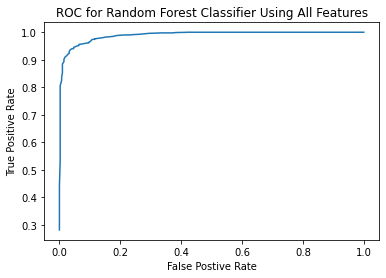

In [5]:
# plot the roc
plot = pd.read_csv('../Outputs/RandomForestClassifier_ROC.csv')
plt.plot(plot['fpr'], plot['tpr'])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Random Forest Classifier Using All Features')
plt.show()

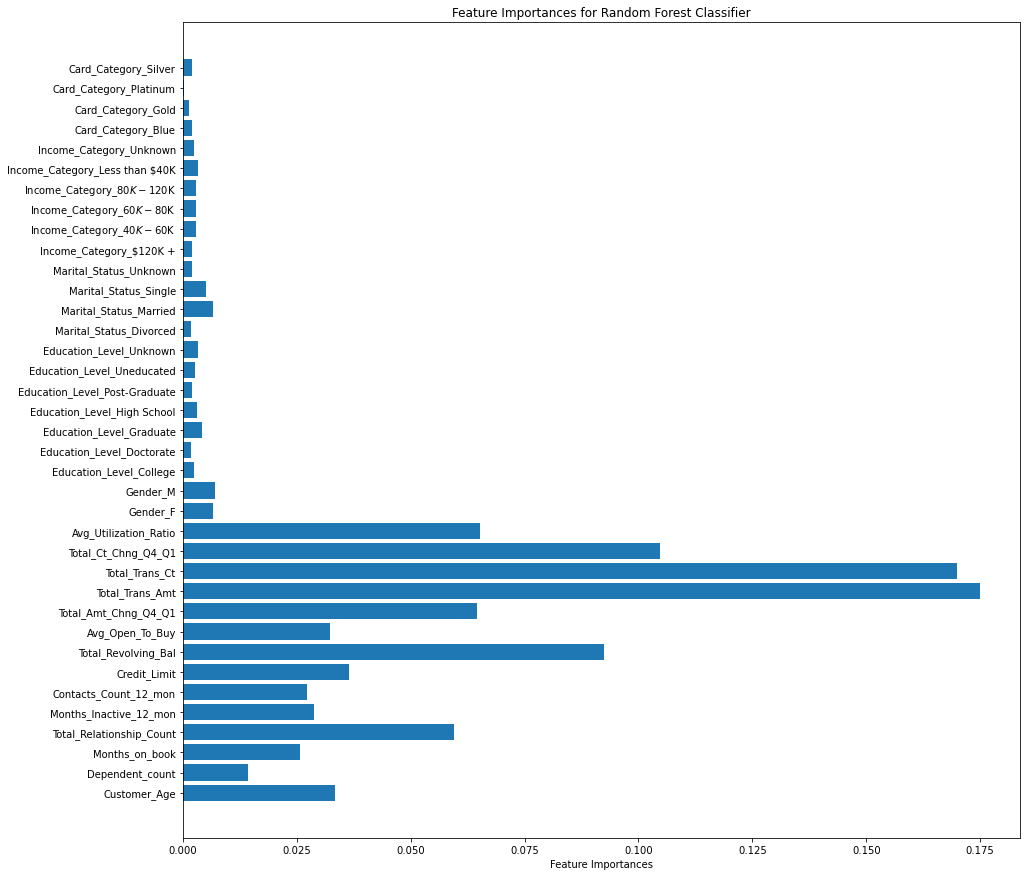

In [6]:
# plot the feature importances
feature_importances = fi(X, y, model='rfc')
ticks = np.arange(len(X.columns))
fig, ax = plt.subplots()
ax.barh(ticks, feature_importances)
ax.set_yticks(ticks, labels=X.columns)
fig.set_size_inches(15, 15)
ax.set_xlabel('Feature Importances')
ax.set_title('Feature Importances for Random Forest Classifier')
plt.show()
pd.DataFrame({'Features': features, 'Feature_Importances': feature_importances}).to_csv('../Outputs/RandomForestClassifier_FI.csv')

## Evaluate Model with Just Demographics Data
The demographic RFC model is created in the same way as the base model except it is only given demographic features data to train on. It scores an accuracy of 79% on the testing data. Not only is this a significantly lower accuracy than the logistic regression and knn models but it is also less than random chance. The initial data is 86% existing customers (14% attrited) meaning that a model that only guesses existing customers for every output will score higher than the demographic RFC. The RFC plot and AUC-ROC show similar results: the ROC is close to a straight line from the origin to (1, 1) meaning that there is an equal trade of between false positive rate and true positive rate when choosing a model threshold. The AUC-ROC score of 50% indicates that the ROC cuts the possibility space into two pieces, confirming that the ROC is approximately and straight line. 

All of this is to say that the demographics RFC model is not a great classifier and that there is probably not much correlation between demographics and attrition on their own. There may be other hidden correlations between demographics and usage features, but on their own they do not seem to train the model beyond random chance.


In [7]:
# get demographics data
Xdem = pd.read_csv('../Resources/X-dem.csv')

In [8]:
# see what features are dempgraphic
features_dem = Xdem.columns.values
print(f'Feature names: {features_dem}')
print(f'Number of Features: {len(features_dem)}')

Feature names: ['Customer_Age' 'Dependent_count' 'Gender_F' 'Gender_M'
 'Education_Level_College' 'Education_Level_Doctorate'
 'Education_Level_Graduate' 'Education_Level_High School'
 'Education_Level_Post-Graduate' 'Education_Level_Uneducated'
 'Education_Level_Unknown' 'Marital_Status_Divorced'
 'Marital_Status_Married' 'Marital_Status_Single' 'Marital_Status_Unknown'
 'Income_Category_$120K +' 'Income_Category_$40K - $60K'
 'Income_Category_$60K - $80K' 'Income_Category_$80K - $120K'
 'Income_Category_Less than $40K' 'Income_Category_Unknown']
Number of Features: 21


In [9]:
# create and score the model
print('Random forest classifiier on demographic data only')
print(f'Accuracy: {acct(Xdem, y, model="rfc")}')
print(f'Area under curve: {auct(Xdem, y, model="rfc", data_set="X-dem")}')

Random forest classifiier on demographic data only
Accuracy: 0.7894944707740916
Area under curve: 0.5049716479912478


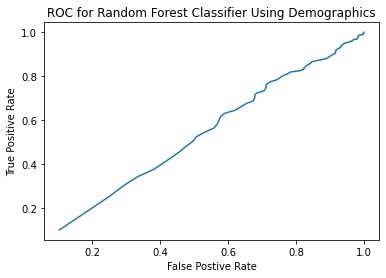

In [10]:
# plot roc
plot_dem = pd.read_csv('../Outputs/X-dem_RandomForestClassifier_ROC.csv')
plt.plot(plot_dem['fpr'], plot_dem['tpr'])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Random Forest Classifier Using Demographics')
plt.show()

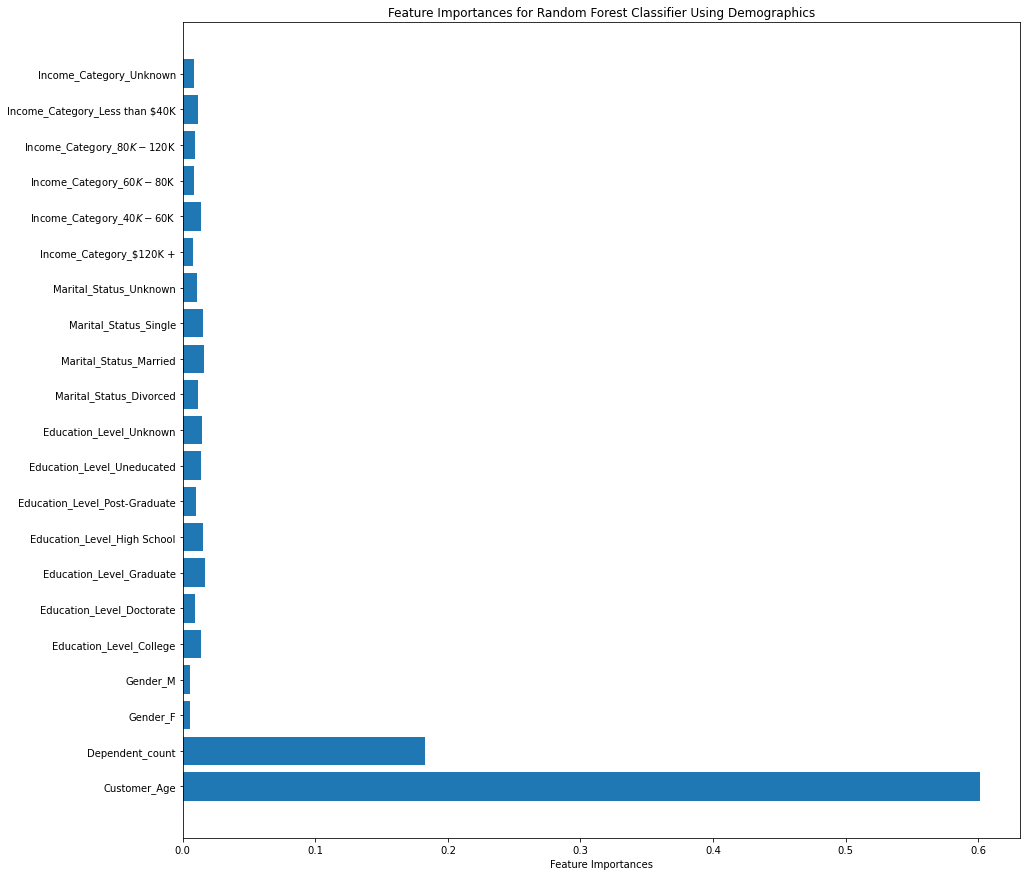

In [11]:
# plot feature importances
feature_importances_dem = fi(Xdem, y, model='rfc')
ticks = np.arange(len(features_dem))
fig, ax = plt.subplots()
ax.barh(ticks, feature_importances_dem)
ax.set_yticks(ticks, labels=features_dem)
fig.set_size_inches(15, 15)
ax.set_xlabel('Feature Importances')
ax.set_title('Feature Importances for Random Forest Classifier Using Demographics')
plt.show()
pd.DataFrame({'Features': features_dem, 'Feature_Importances': feature_importances_dem}).to_csv('../Outputs/X-dem_RandomForestClassifier_FI.csv')

## Evaluate Model with PCA
While the demographics data did not produce an RFC model that could make prediction better than chance, it is still possible to create an accurate model with less than the full set of data. PCA is used to project samples onto a subspace of the feature space that preserves the most variation to noise in the output. The PCA RFC model is trained with data that is dimensionally reduced using PCA and tested with data that uses the same PCA transformation. The testing accuracy score is 87% - similar to logistic regression and knn models. This model shows that it is possible to produce an accurate model with reduced dimensionality if the *right* combination of features are used.


In [12]:
# import dependencies to do pca and run model locally (mechlearn module is not compatible with pca)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier as RFC
from mechlearn import roc

# split and scale the data
_Xs, Xs_, _ypca, ypca_ = ss(X, y)

# perform pca with 21 components
pca = PCA(n_components=21)

# fit data
_Xspca, Xspca_ = pca.fit_transform(_Xs), pca.transform(Xs_)

# view component variance
print(f'Variance ratio of components: {[round(variance,2) for variance in pca.explained_variance_ratio_]}')
print(f'Number of components: 21')

Variance ratio of components: [0.12, 0.07, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
Number of components: 21


In [13]:
# create and score model
rfc_pca = RFC()
rfc_pca.fit(_Xspca, _ypca.to_numpy().ravel())
score = rfc_pca.score(Xspca_, ypca_)
auc = roc(Xspca_, ypca_, rfc_pca, 100, area=True, save_path='../Outputs/X-pca_RandomForestClassifier_ROC.csv')
print('Random forest classifiier with PCA')
print(f'Accuracy: {score}')
print(f'Area under curve: {auc}')

Random forest classifiier with PCA
Accuracy: 0.8684834123222749
Area under curve: 0.8623902067079123


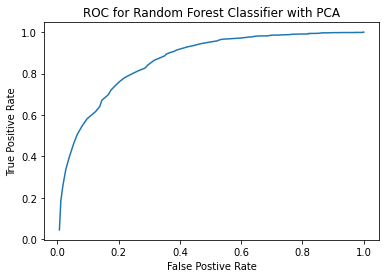

In [14]:
# plot roc
plot_pca = pd.read_csv('../Outputs/X-pca_RandomForestClassifier_ROC.csv')
plt.plot(plot_pca['fpr'], plot_pca['tpr'])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Random Forest Classifier with PCA')
plt.show()

## Conclusions
The base RFC model, trained with all features of the credit card churn data set, scores a high accuracy and appears to be a useful model for predicting credit card churn. In addition to the high accuracy of 94%, the model also possesses an ROC with a high 99% AUC meaning the model can be tuned to fit the use case. For both of these aspects, RFC outperforms the logistic regression and knn models and shows similar results to a neural network.  

Accuracy is lost when trying to make models trained on fewer features and the predictive power cannot fully match the model trained with all the features, which is expected. The demographics model does not show to perform any better than random chance and because of this, it does not make a good model for predicting credit card churn. The PCA model does perform better and on much larger sets of data this set might be necessary to save time and resources on model training. Still it is significantly less accurate than the base model and if the use case requires high accuracy, a neural net or the base model would be necessary.

Further analysis could explore using the demographics data to first predict key usage features and then use the usage features to predict churn (which has already been shown to be effective with the base model). This type of compounded model could be successful if a correlation exists between usage and demographics. The data set is constrained by only having around 16% attrited customers. Another thing to explore is synthesizing more attrited data to see if these models hold for a more balanced data set. 


## Other Analysis
This section creates some plots for visualizing how the model performs on demographic data.

In [15]:
# this code generates a plot of to visualize how the prediction and targets is distributed across different slices of demographics
def feature_variance(df, feature, save_path=None, show_error=False, method='mean'):
    all_features = df.columns
    dfi = df.copy(deep=False)
    if not feature in all_features:
        type = 'cat'
        dfi[feature] = 1
        encoded_features = list(filter(lambda feature_: feature in feature_, all_features))
        for feature_ in encoded_features:
            dfi[feature] = dfi.apply(lambda x: feature_.replace(f'{feature}_', '') if x[feature_] == 1 else x[feature], axis=1)
    else:
        type = 'con'
    if method == 'mean':
        dfr = dfi.groupby(feature).mean()
        dfr['target_variance'] = dfi.groupby(feature).std()['target']
        dfr['prediction_variance'] = dfi.groupby(feature).std()['prediction']
    elif method == 'median':
        dfr.groupby(feature)
        dfr = dfi.groupby(feature).median()
    dfr.dropna(inplace=True)
    if type == 'cat':
        N = len(dfr)
        ind = np.arange(N)
        width = 0.3
        plt.bar(ind, dfr['prediction'], width, color='red', alpha=.5, label=f'{method.capitalize()} Prediction')
        plt.bar(ind + width, dfr['target'], width, color='blue', alpha=.5, label=f'{method.capitalize()} Target')
        plt.xticks(ind + width / 2, dfr.index, rotation=45)
        if show_error and method != 'median':
            plt.errorbar(ind, dfr['prediction'], dfr['prediction_variance'], color='red', fmt='o')
            plt.errorbar(ind + width, dfr['target'], dfr['target_variance'], color='blue', fmt='o')
    else:
        plt.plot(dfr.index, dfr['prediction'].values, c='red', label=f'{method.capitalize()} Prediction')
        plt.plot(dfr.index, dfr['target'], c='blue', label=f'{method.capitalize()} Target')
        if show_error and method != 'median':
            plt.fill_between(dfr.index, dfr['prediction']+dfr['prediction_variance'], y2=dfr['prediction']-dfr['prediction_variance'], color='red', alpha=.1)
            plt.fill_between(dfr.index, dfr['target']+dfr['target_variance'], y2=dfr['target']-dfr['target_variance'], color='blue', alpha=.1)
    plt.legend()
    plt.title(f'RFC Prediciton Across {feature.replace("_", " ").title()}')
    if type == 'con':
        plt.xlim(dfr.index.min(), dfr.index.max())
    plt.ylim(0 ,1)
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel("Proportion of Samples\nthat are 'Low Risk'")
    if not save_path == None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

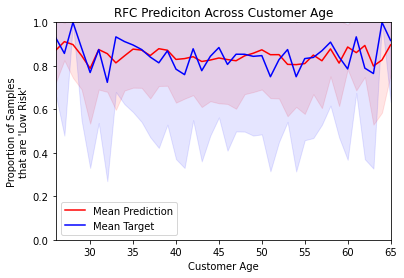

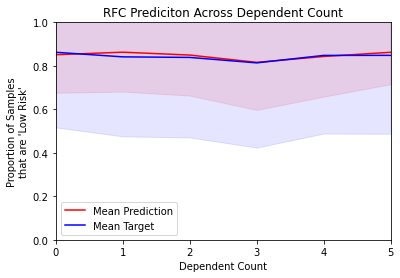

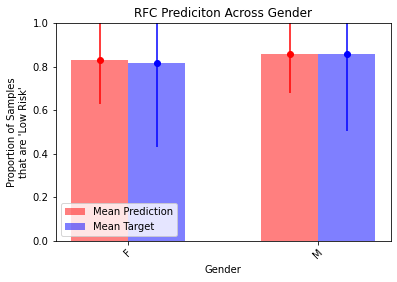

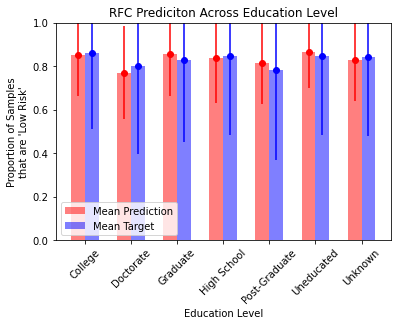

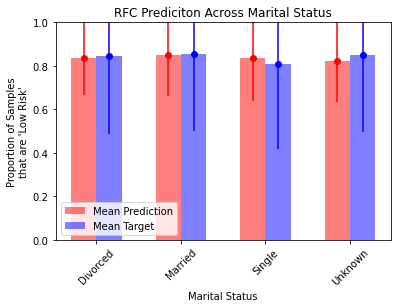

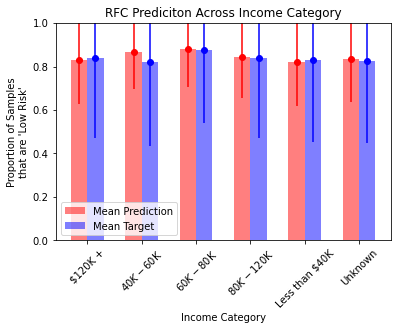

In [16]:
#  load data from model that was trained in model.py (and is used on website)
D_ = pd.read_csv('../resources/D_.csv')

# list all demographics
demographics = ['Customer_Age', 'Dependent_count', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category']

# create plot for each demographic
for demographic in demographics:
    feature_variance(D_, demographic, save_path=f'../static/assets/{demographic}_view.png', show_error=True)